In [2]:
# library imports
import random

import os
import cv2
import pdb
import time
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt


# for reproducibility
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

import os
from os.path import join
import sys
import skimage.io
from pathlib import Path

!pip install plotly

# visuals
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# paths
root_dir = './severstal-steel-defect-detection/'
img_train_folder = Path(join(root_dir, 'train_images/'))
img_test_folder = Path(join(root_dir,'test_images/'))

<a id="1"></a> <br>
# Competition Information

## Prediction Output Format
From the competition's [data](https://www.kaggle.com/c/severstal-steel-defect-detection/data) page:
> Each image may have no defects, a defect of a single class, or defects of multiple classes. For each image you must segment defects of each class ```(ClassId = [1, 2, 3, 4])```.

The submission format requires us to make the classifications for each respective class on a separate row:
![format](https://i.imgur.com/x3rWaJP.png)

## Loss Function

### Dice Coefficient
From the [evaluation](https://www.kaggle.com/c/severstal-steel-defect-detection/overview/evaluation) page:

> This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:
>
>$$Dice(X,Y) = \frac{2∗|X∩Y|}{|X|+|Y|}$$
>
>
>where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each ```<ImageId, ClassId>``` pair in the test set.

Or if you prefer a visual illustration:
![dice_viz](https://i.imgur.com/zl2W0xQ.png)


To get a better understanding, let's demonstrate with a quick toy example as we write the function:

In [3]:
# imagine a 3*3 image with a diagional line across
X = np.eye(3,3, dtype=np.uint8)
Y = np.eye(3,3, dtype=np.uint8)

# we change one pixel
X[1,1] = 0

print(X)
print('')
print(Y)

[[1 0 0]
 [0 0 0]
 [0 0 1]]

[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [4]:
def dice_coefficient(X, y):
    
    # convert the pixel/mask matrix to a one-dimensional series
    predicted = X.flatten()
    truth = y.flatten()
    
    # our masks will consist of ones and zeros
    # summing the result of their product gives us the cross section
    overlap = np.sum(predicted * truth)
    total_surface_area = np.sum(predicted + truth)
    
    # passing our calculated values to the formula
    return 2 * overlap / total_surface_area

In [5]:
print(f'The dice coefficient for 1 wrongly labeled pixel in a 3*3 image is: {dice_coefficient(X, Y)}')
print('(2 * 2 overlapping "1" pixels / 5 total "1" surface area)')

The dice coefficient for 1 wrongly labeled pixel in a 3*3 image is: 0.8
(2 * 2 overlapping "1" pixels / 5 total "1" surface area)


### *Mean* Dice Coefficient
The dataset's original format (one row per *imageId:classId* pair) points at the fact that we will have to run this dice coefficient function over every layer in our mask and take the average. If we train multiple images at a time, we will have to take the average across a batch. More about this in the **Data Shapes** chapter.

## Run-Length Encoding
> In order to reduce the submission file size, our metric uses run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices for your segmentation, you will submit **pairs of values** that contain a **start position and a run length**. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).
>
>The competition format requires a **space delimited list of pairs**. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are **sorted, positive, and the decoded pixel values are not duplicated**. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

So, if we were to encode something like our example above, we would have to write it as follows:

In [6]:
# a more elaborate version of kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
# note that we will transpose the incoming array outside of the function, 
# as I find this a clearer illustration

def mask_to_rle(mask):
    """
    params:  mask - numpy array
    returns: run-length encoding string (pairs of start & length of encoding)
    """
    
    # turn a n-dimensional array into a 1-dimensional series of pixels
    # for example:
    #     [[1. 1. 0.]
    #      [0. 0. 0.]   --> [1. 1. 0. 0. 0. 0. 1. 0. 0.]
    #      [1. 0. 0.]]
    flat = mask.flatten()
    
    # we find consecutive sequences by overlaying the mask
    # on a version of itself that is displaced by 1 pixel
    # for that, we add some padding before slicing
    padded = np.concatenate([[0], flat, [0]])
    
    # this returns the indeces where the sliced arrays differ
    runs = np.where(padded[1:] != padded[:-1])[0] 
    # indexes start at 0, pixel numbers start at 1
    runs += 1

    # every uneven element represents the start of a new sequence
    # every even element is where the run comes to a stop
    # subtract the former from the latter to get the length of the run
    runs[1::2] -= runs[0::2]
 
    # convert the array to a string
    return ' '.join(str(x) for x in runs)

In [7]:
rle_example = mask_to_rle(X)
print(f'The run-length encoding for our example would be: "{rle_example}"')

The run-length encoding for our example would be: "1 1 9 1"


In [8]:
def rle_to_mask(lre, shape=(1600,256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    # the incoming string is space-delimited
    runs = np.asarray([int(run) for run in lre.split(' ')])
    
    # we do the same operation with the even and uneven elements, but this time with addition
    runs[1::2] += runs[0::2]
    # pixel numbers start at 1, indexes start at 0
    runs -= 1
    
    # extract the starting and ending indeces at even and uneven intervals, respectively
    run_starts, run_ends = runs[0::2], runs[1::2]
    
    # build the mask
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    
    # transform the numpy array from flat to the original image shape
    return mask.reshape(shape)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [9]:
print(f'The mask reconstructed from the run-length encoding ("{rle_example}") \
for our example would be:\n{rle_to_mask(rle_example, shape=(3,3))}')

The mask reconstructed from the run-length encoding ("1 1 9 1") for our example would be:
[[1 0 0]
 [0 0 0]
 [0 0 1]]


<a id="2"></a> <br>
# Exploratory Data Analysis

## Class Imbalances
A huge imbalance quickly becomes apparent when looking at the training set description:

![class_imbalance](https://i.imgur.com/B4Dsxur.png)

Only 7095 pictures will be of any use to us when training... (you wouldn't train a pedestrian detector on a dataset of empty streets, either).

## Baseline
If we'd train on the entire dataset, the risk is substantial that our model will simply learn the **majority class** (no defect, ever).
Indeed, if we simply upload the sample submission, we have a score of:

![baseline_code](https://i.imgur.com/zAxYg4g.png)
![baseline_score](https://i.imgur.com/AXaygTV.png)

This is the benchmark to beat. 

## Class Imbalances (continued)
Let's see how often each class appears, as well as how the class distribution is inside images.

In [10]:
# reading in the training set
data = pd.read_csv(join(root_dir,'train.csv'))
data['ClassId'] = data['ClassId'].astype(np.uint8)

data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   uint8 
 2   EncodedPixels  7095 non-null   object
dtypes: object(2), uint8(1)
memory usage: 117.9+ KB


,ImageId,ClassId,EncodedPixels
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...
7094,ffffd67df.jpg,3,30931 43 31103 127 31275 211 31489 253 31745 2...


In [11]:
# keep only the images with labels
squashed = data.dropna(subset=['EncodedPixels'], axis='rows', inplace=True)

# squash multiple rows per image into a list
squashed = (
    data[['ImageId', 'EncodedPixels', 'ClassId']]
        .groupby('ImageId', as_index=False) 
        .agg(list) 
)

# count the amount of class labels per image
squashed['DistinctDefectTypes'] = squashed['ClassId'].apply(lambda x: len(x))

# display first ten to show new structure
squashed.head(10)

,ImageId,EncodedPixels,ClassId,DistinctDefectTypes
0,0002cc93b.jpg,[29102 12 29346 24 29602 24 29858 24 30114 24 ...,[1],1
1,0007a71bf.jpg,[18661 28 18863 82 19091 110 19347 110 19603 1...,[3],1
2,000a4bcdd.jpg,[37607 3 37858 8 38108 14 38359 20 38610 25 38...,[1],1
3,000f6bf48.jpg,[131973 1 132228 4 132483 6 132738 8 132993 11...,[4],1
4,0014fce06.jpg,[229501 11 229741 33 229981 55 230221 77 23046...,[3],1
5,0025bde0c.jpg,[8458 14 8707 35 8963 48 9219 71 9475 88 9731 ...,"[3, 4]",2
6,002af848d.jpg,[290800 6 291055 13 291311 15 291566 18 291822...,[4],1
7,002fc4e19.jpg,[146021 3 146275 10 146529 40 146783 46 147038...,"[1, 2]",2
8,0030401a5.jpg,[186833 1 187089 3 187344 6 187600 7 187855 10...,[4],1
9,0046839bd.jpg,[152926 1 153180 4 153434 6 153689 8 153943 11...,[3],1


In [12]:
""" use a consistent color palette per label throughout the notebook """
import colorlover as cl

# see: https://plot.ly/ipython-notebooks/color-scales/
colors = cl.scales['4']['qual']['Set3']
labels = np.array(range(1,5))

# combining into a dictionary
palette = dict(zip(labels, np.array(cl.to_numeric(colors))))

In [13]:
# we want counts & frequency of the labels
classes = (
    data.groupby(by='ClassId', as_index=False)
        .agg({'ImageId':'count'})
        .rename(columns={'ImageId':'Count'})
)

classes['Frequency'] = round(classes['Count'] / classes['Count'].sum() * 100, 2) 
classes['Frequency'] = classes['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=classes.Count,
        y=classes.ClassId,
        hovertext=classes.Frequency,
        text=classes.Count,
        textposition='auto',
        marker_color=colors),
    
    layout=go.Layout(
        title='Defect Type: Count & Frequency',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=400
    )
)

# display
fig.show()

An overwhelming amount of the observations is for class 3. Hopefully we can balance this out at least a little with some data augmentation later.

Let's see what the distributions are if we consider all possible combinations, including multi-class instances.

In [14]:
# we want counts of the possible combinations of labels
permutations = pd.DataFrame(data=squashed.ClassId.astype(str).value_counts())

# and their frequency
permutations['Frequency'] = round(permutations['ClassId'] / permutations['ClassId'].sum() * 100, 2)
permutations['Frequency'] = permutations['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=permutations.ClassId,
        y=permutations.index,
        hovertext=permutations.Frequency,
        text=permutations.ClassId,
        textposition='auto'),
    
    layout=go.Layout(
        title='Count of Distinct Defect Combinations in Images',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=500
    )
)

# display
fig.show()

It looks like combinations of two labels in a single image are reasonably frequent, too. In fact, 3 & 4 appear together more often than 2 does on its own!

<a id="3"></a> <br>
# Data Shapes

## Images
The input shape will be an image we convert to a three-dimensional array with shape ```(256, 1600, 3)```, for height, width, and the three colour channels (RGB), respectively.

## Labels
Naturally, the masks will share the same width and height, but the third dimension will be as large as there are labels ```(256, 1600, 4)```, with each class occupying a different layer. Somewhat like this:
![label shape](https://i.imgur.com/PePSemo.png)

## Batch Size
To leverage the parellel computation a GPU offers, we will feed the images and their labels to the algorithm in batches. Consequently, our array dimensions will be expanded to ```(batch size, 256, 1600, 3)``` and ```(batch size, 256, 1600, 4)```, respectively.

If you remember our dice coefficient, we will have to calculate it for evey layer in every mask, and take the average over the entire batch.

<a id="4"></a> <br>
# Visualising the Masks
Let's take a look at some examples of each class, and of some of the images containing multiple classes.

In [15]:
def build_mask(encodings, labels):
    """ takes a pair of lists of encodings and labels, 
        and turns them into a 3d numpy array of shape (256, 1600, 4) 
    """
    
    # initialise an empty numpy array 
    mask = np.zeros((256,1600,4), dtype=np.uint8)
   
    # building the masks
    for rle, label in zip(encodings, labels):
        
        # classes are [1, 2, 3, 4], corresponding indeces are [0, 1, 2, 3]
        index = label - 1
        
        # fit the mask into the correct layer
        # note we need to transpose the matrix to account for 
        # numpy and openCV handling width and height in reverse order 
        mask[:,:,index] = rle_to_mask(rle).T
    
    return mask

In [16]:
def mask_to_contours(image, mask_layer, color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """

    # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
    contours, hierarchy = cv2.findContours(mask_layer, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image = cv2.drawContours(image, contours, -1, color, 2)
        
    return image

In [17]:
def visualise_mask(file_name, mask):
    """ open an image and draws clear masks, so we don't lose sight of the 
        interesting features hiding underneath 
    """
    
    # reading in the image
    image = cv2.imread(f'{img_train_folder}/{file_name}')

    # going through the 4 layers in the last dimension 
    # of our mask with shape (256, 1600, 4)
    for index in range(mask.shape[-1]):
        
        # indeces are [0, 1, 2, 3], corresponding classes are [1, 2, 3, 4]
        label = index + 1
        
        # add the contours, layer per layer 
        image = mask_to_contours(image, mask[:,:,index], color=palette[label])   
        
    return image

            ImageId                                      EncodedPixels  \
2992  73a4c6d1f.jpg  [351934 7 352189 9 352444 11 352699 11 352954 ...   
3938  97bf2a97c.jpg  [15718 9 15956 27 16194 45 16441 53 16697 53 1...   

     ClassId  DistinctDefectTypes  
2992     [1]                    1  
3938     [1]                    1  
            ImageId                                      EncodedPixels  \
1117  2b01fd731.jpg  [113559 15 113816 43 114072 72 114329 86 11458...   
150   060964105.jpg  [124675 21 124931 61 125187 102 125443 142 125...   

     ClassId  DistinctDefectTypes  
1117     [2]                    1  
150      [2]                    1  
            ImageId                                      EncodedPixels  \
6199  ed54a41e1.jpg  [1152 26 1290 36 1376 76 1545 181 1799 201 205...   
5982  e4fe95209.jpg  [227030 43 227201 128 227372 5318 232705 213 2...   

     ClassId  DistinctDefectTypes  
6199     [3]                    1  
5982     [3]                    1  
       

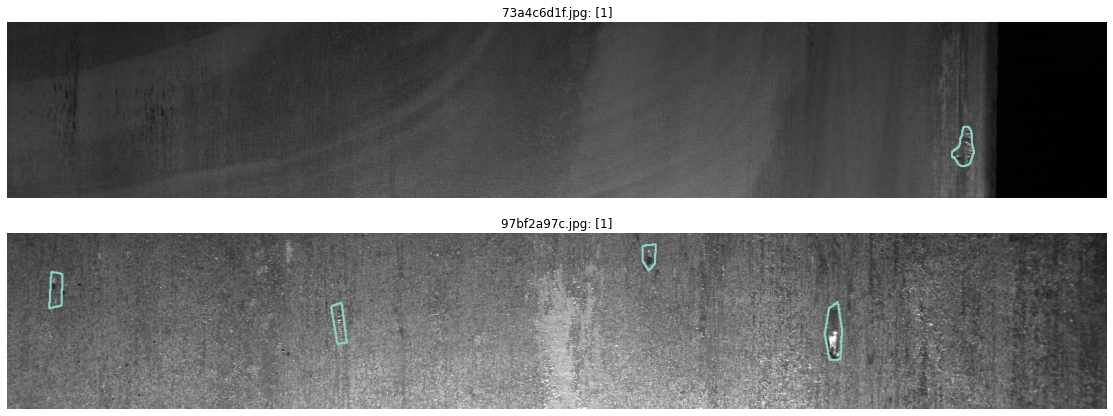

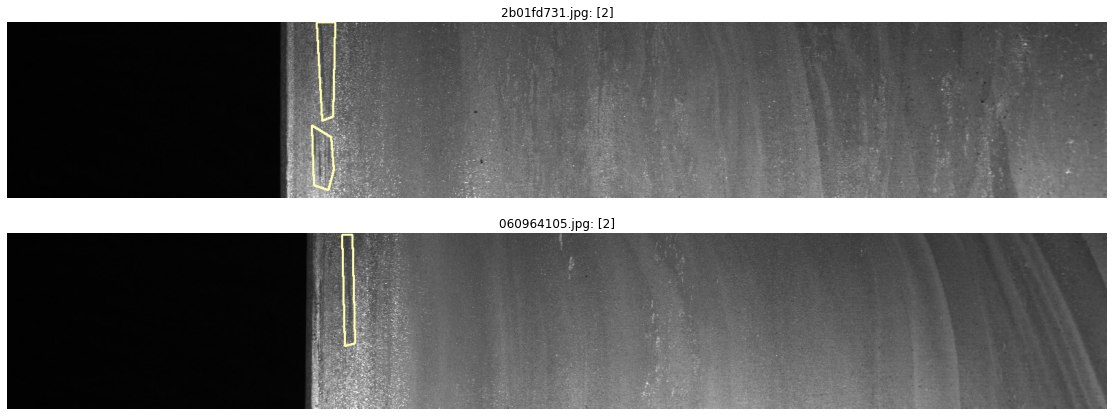

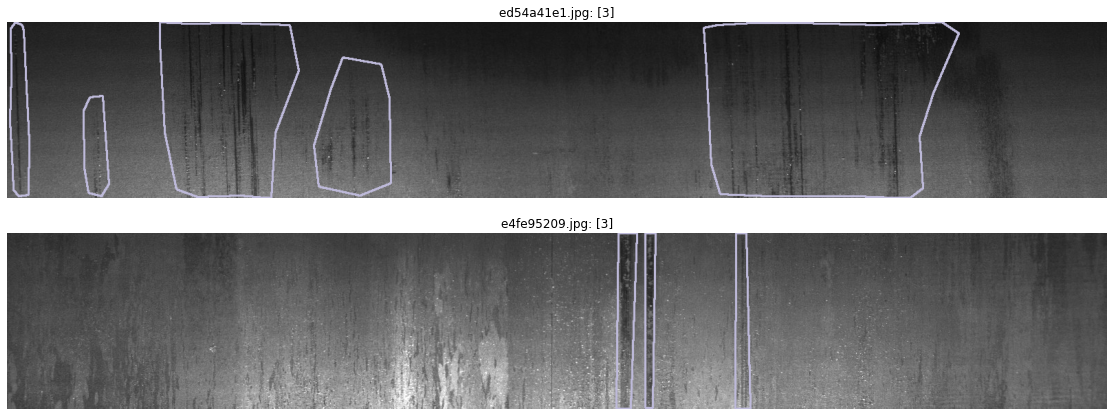

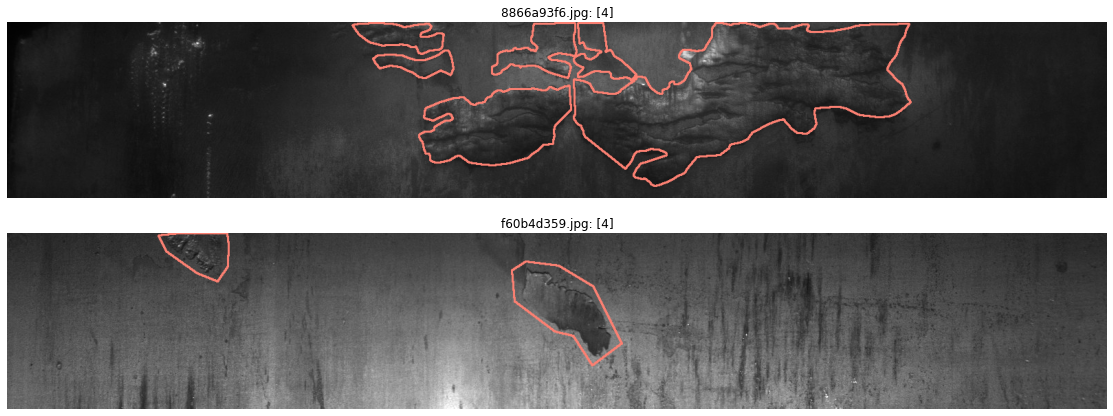

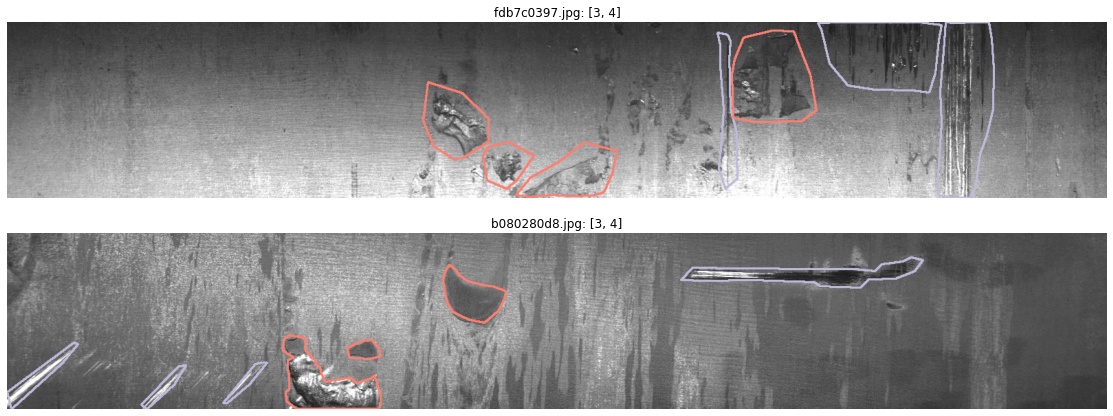

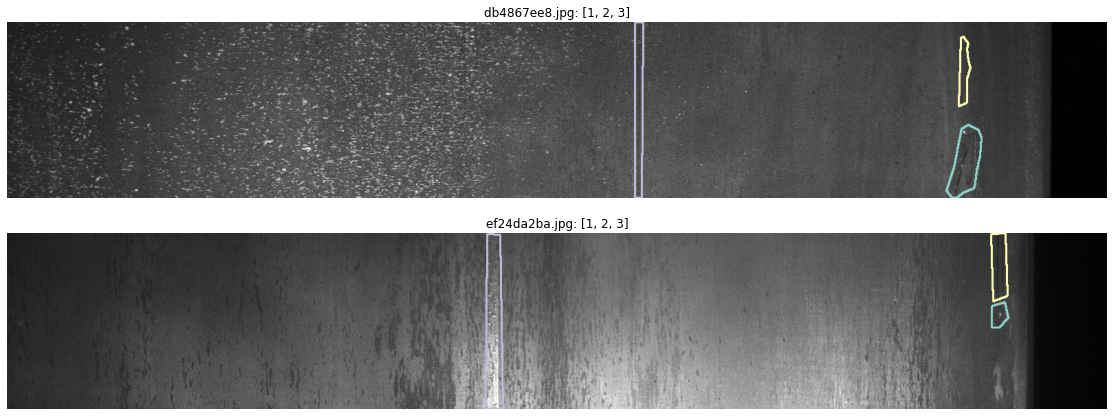

In [20]:
# the images we want to see
conditions = [
    squashed['ClassId'].astype(str)=='[1]',
    squashed['ClassId'].astype(str)=='[2]',
    squashed['ClassId'].astype(str)=='[3]',
    squashed['ClassId'].astype(str)=='[4]',
    squashed['DistinctDefectTypes']==2,
    squashed['DistinctDefectTypes']==3
]

# max 2 due to limited population of [squashed['Distinct Defect Types']==3]
# remove that condition if you wish to increase the sample size, 
# or add replace=True to the .sample() method
sample_size = 2

# looping over the different combinations of labels 
for condition in conditions:
    
    # isolate from dataset and draw a sample
    sample = squashed[condition].sample(sample_size) 
    print(sample)
    
    # make a subplot+
    fig, axes = plt.subplots(sample_size, 1, figsize=(16, sample_size*3))
    fig.tight_layout()
    
    # looping over sample
    for i, (index, row) in enumerate(sample.iterrows()):
        
        # current ax
        ax = axes[i,]
        
        # build the mask
        mask = build_mask(encodings=row.EncodedPixels, labels=row.ClassId)
        # print(mask)
        # fetch the image and draw the contours
        image = visualise_mask(file_name=row.ImageId, mask=mask)
        
        # display
        ax.set_title(f'{row.ImageId}: {row.ClassId}')
        ax.axis('off')
        ax.imshow(image);

<a id="5"></a> <br>
# Semantic Segmentation
Below are some of the common tasks in the field of Machine Vision:
![semantic_segmentation](https://miro.medium.com/max/1838/1*Tb3CvTONAA4IVL-HciJscw.jpeg)

We are dealing with the problem of semantic segmentation: predicting a pixel-by-pixel mask of distinct classes.
Check out Priya Dwivedi's [excellent blogpost](https://towardsdatascience.com/semantic-segmentation-popular-architectures-dff0a75f39d0) on the topic if you want to read more.

<a id="6"></a> <br>
# Mask R-CNN
Mask R-CNN falls under the category of meta-algorithms, rather than purely a neural network architecture. In fact, it builds on the faster R-CNN architecture, so you even have a choice of what neural net 'backbone' you want it to use.

![maskrcnn-framework](https://miro.medium.com/max/1285/1*IWWOPIYLqqF9i_gXPmBk3g.png)


The most important aspects of this algorithm are:
* **FPN (feature pyramid network)** - A fully convolutional neural architecture designed to extract features.
* **RPN (region proposal network)** - A lightweight neural network that scans over the FPN features to suggest ROI (regions of interest)
* **ROIAlign** - a novel way to pass the object to the classifier an mask generator. Contrary to the ROIpool mechanism that was the standard, this one uses [bilinear interpolation](https://www.quora.com/How-does-ROTAlign-work-in-Mask-RCNN) to improve performance significantly.
* **Classifier & Bounding Box Regressor**. 
* **Mask Generator** - A convolutional network that takes the regions selected by the ROI classifier and generates soft masks for them. 

Read more on [Matterport's official blog](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46) <br>
You can also check out the original paper's authors presenting the Mask R-CNN [on YouTube](https://youtu.be/g7z4mkfRjI4)

## Importing
For instructions on how to import models into a Kaggle kernel, check out the following Medium article: [Setting Up Mask-RCNN on Kaggle](https://medium.com/@umdfirecoml/setting-up-mask-rcnn-on-kaggle-34b656140b5e)

2019/10/10: <br> 
This method currently produces an error message when committing. <br> 
```Output path '/Mask_RCNN/.git/logs/refs/remotes/origin/HEAD' contains too many nested subdirectories (max 6)```. <br> 
I resort to Simon Walker's method to get around this.

2019/10/17: <br>
A Keras update means the model now produces an error [documented in issue #1754](https://github.com/matterport/Mask_RCNN/issues/1754). <br>
I therefore cloned the repo and applied a small fix. <br>
```changing: self.keras_model.metrics_tensors.append(loss)
to: self.keras_model.add_metric(loss, name)````


In [ ]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    # df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

In [ ]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [42]:
from segmentation_models_pytorch import Unet
model = Unet("resnet18", encoder_weights="imagenet", classes=4, activation=None)

In [46]:
from torchsummary import summary
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [47]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 20
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()

In [48]:
root_dir

'./severstal-steel-defect-detection/'

In [49]:
sample_submission_path = join(root_dir,'sample_submission.csv')
train_df_path = join(root_dir,'train.csv')
data_folder = root_dir
test_data_folder = join(root_dir,'test_images')

In [50]:
model_trainer = Trainer(model)
model_trainer.start()

TypeError: type torch.cuda.FloatTensor not available. Torch not compiled with CUDA enabled.